# ***Download package and import libaries***

In [16]:
!pip install transformers accelerate timm datasets albumentations opencv-python evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import torch ,  os , torchvision , evaluate
import albumentations
import numpy as np

from datasets import load_dataset
from torch.utils.data import Dataset , DataLoader
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from PIL import Image, ImageDraw

from tqdm import tqdm
from transformers import TrainingArguments, Trainer
from transformers import AutoFeatureExtractor, AutoModelForObjectDetection


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Data processing***

In [20]:
# Sử dụng tập dataset CPPE : https://huggingface.co/datasets/cppe-5
cppe_dataset = load_dataset("cppe-5")

  0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
# Kiểm tra bộ dataset
cppe_dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [22]:
# Loại bỏ các ảnh lỗi
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe_dataset["train"])) if i not in remove_idx]
cppe_dataset["train"] = cppe_dataset["train"].select(keep)
cppe_dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 993
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [23]:
# Kiểm tra dữ liệu đầu tiên của tập train
example = cppe_dataset['train'][0]
example

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663 at 0x7F07988ABC10>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

In [24]:
# Khởi tạo categories dùng để chứa label
categories = cppe_dataset["train"].features["objects"].feature["category"]

# Khởi tạo thư viện chuyển đổi id về label
id2label = {index: x for index, x in enumerate(categories.names, start=0)}
# Khởi tạo thư viện chuyển đổi label về id
label2id = {v: k for k, v in id2label.items()}

print(categories)
print(id2label)
print(label2id)

ClassLabel(names=['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'], id=None)
{0: 'Coverall', 1: 'Face_Shield', 2: 'Gloves', 3: 'Goggles', 4: 'Mask'}
{'Coverall': 0, 'Face_Shield': 1, 'Gloves': 2, 'Goggles': 3, 'Mask': 4}


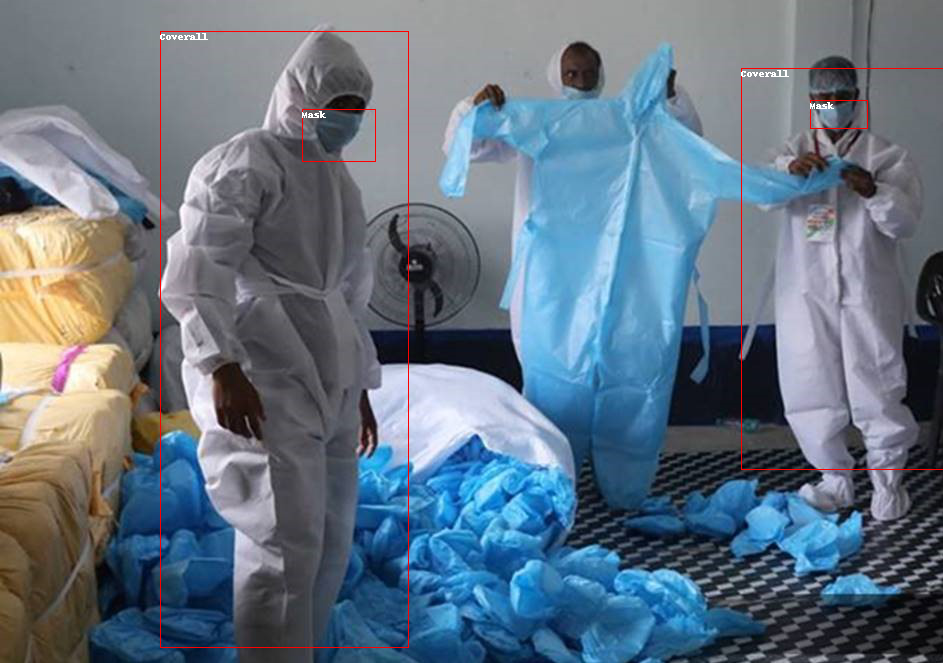

In [25]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = example["image"]
annotations = example["objects"]
draw = ImageDraw.Draw(image)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [26]:
transform = albumentations.Compose([
    albumentations.Resize(480, 480),
    albumentations.HorizontalFlip(p=1.0),
    albumentations.RandomBrightnessContrast(p=1.0),
], bbox_params=albumentations.BboxParams(format='coco',  label_fields=['category']))

# RGB PIL Image -> BGR Numpy array
image = np.flip(np.array(example['image']), -1)
out = transform(
    image=image,
    bboxes=example['objects']['bbox'],
    category=example['objects']['category'],
)

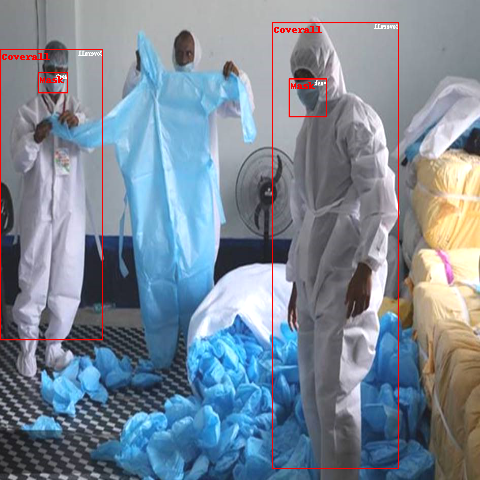

In [27]:
image = torch.tensor(out['image']).flip(-1).permute(2, 0, 1)
boxes_xywh = torch.stack([torch.tensor(x) for x in out['bboxes']])
boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
labels = [categories.int2str(x) for x in out['category']]
to_pil_image(
    draw_bounding_boxes(
        image,
        boxes_xyxy,
        colors='red',
        labels=labels
    )
)

In [28]:
# Hàm chuấn hóa object theo giống dataset của huggingface
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# Chuyển đổi n_batch
def transform_aug_ann(examples,image_processor,transform):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [29]:
import json
# Định dạng lại file test , không cần phải xử lý ảnh
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations

# Lưu ảnh và object vào torchvision.datasets.CPPEDetection 
def save_cppe_annotation_file_images(cppe):
    output_json = {}
    path_output_cppe = f"/content/drive/MyDrive/Deep_Learning/Final_term/cppe/"

    if not os.path.exists(path_output_cppe):
        os.makedirs(path_output_cppe)

    path_anno = os.path.join(path_output_cppe, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe["image"], cppe["image_id"]):
        path_img = os.path.join(path_output_cppe, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe, path_anno

path_output_cppe, path_anno = save_cppe_annotation_file_images(cppe_dataset["test"])

In [30]:
class CPPEDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CPPEDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


In [31]:
def collate_fn(batch,image_processor,choice = 0):
    if choice == 0: # Sử dụng pixel_mask
      pixel_values = [item["pixel_values"] for item in batch]
      encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
      labels = [item["labels"] for item in batch]
      batch = {}
      batch["pixel_values"] = encoding["pixel_values"]
      batch["pixel_mask"] = encoding["pixel_mask"]
      batch["labels"] = labels
    if choice == 1:
      pixel_values = [item["pixel_values"] for item in batch]
      encoding = image_processor.pad(pixel_values, return_tensors="pt")
      labels = [item["labels"] for item in batch]
      batch = {}
      batch["pixel_values"] = encoding["pixel_values"]
      batch["labels"] = labels

    return batch

# ***DETR model***

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForObjectDetection
# Sử dụng cuda hoặc cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Sử dụng image processing của mô hình
extractor = AutoFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
# Tải mô hình 
detr = AutoModelForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Kiểm tra 
print(cppe_dataset["train"].with_transform(lambda x : transform_aug_ann(x,extractor,transform))[0])

{'pixel_values': tensor([[[-1.1418, -1.1418, -1.1418,  ..., -0.8678, -0.8678, -0.8678],
         [-1.1418, -1.1418, -1.1418,  ..., -0.8678, -0.8678, -0.8678],
         [-1.1418, -1.1418, -1.1418,  ..., -0.8849, -0.8849, -0.8849],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.0494, -2.0837, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.0152, -2.0494, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-1.0728, -1.0728, -1.0728,  ..., -0.8627, -0.8627, -0.8627],
         [-1.0728, -1.0728, -1.0728,  ..., -0.8627, -0.8627, -0.8627],
         [-1.0728, -1.0728, -1.0728,  ..., -0.8803, -0.8803, -0.8803],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -1.7381, -1.7206, -1.7031],
         [-2.0182, -2.0182, -2.0357,  ..., -1.7206, -1.7031, -1.7031],
         [-2.0007, -2.0182, -2.0357,  ..., -1.7206, -1.7031, -1.7031]],

        [[-0.8458, -0.8458, -0.8458,  ..., -0.7413, -0.7413, -0.7413],
         [-0.8458, -0.8458, 

In [ ]:
from transformers import TrainingArguments, Trainer
# Sử dụng cuda hoặc cpu
device = 'cuda' if torch.cuda.is_available() else False
load_train = True

# Siêu tham số training
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Deep_Learning/Final_term/checkpoint/detr_resnet50",
    per_device_train_batch_size=8,
    num_train_epochs=30,
    fp16=True if device == 'cuda' else False,
    save_steps=3500,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

# Tạo train
trainer = Trainer(
    model=detr,
    args=training_args,
    data_collator= lambda x : collate_fn(x,extractor),
    train_dataset= cppe_dataset["train"].with_transform(lambda x : transform_aug_ann(x,extractor,transform)),
    tokenizer=extractor,
)

if not load_train:
  trainer.train()
else:
  checkpoint_path = "/content/drive/MyDrive/Deep_Learning/Final_term/checkpoint/detr_resnet50/checkpoint-3500"
  extractor = AutoFeatureExtractor.from_pretrained(checkpoint_path)
  detr = AutoModelForObjectDetection.from_pretrained(
    checkpoint_path,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,).to(device)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
This method is deprecated and will be removed in v4.27.0. Please use pad instead.


Step,Training Loss
50,3.787100
100,2.938800
150,2.544200
200,2.334400
250,2.197900
300,2.138400
350,2.095900
400,2.189400
450,2.061500
500,1.949300


In [ ]:
import evaluate
from tqdm import tqdm

module = evaluate.load("ybelkada/cocoevaluate", coco=CPPEDetection(path_output_cppe, extractor, path_anno).coco)
val_dataloader = torch.utils.data.DataLoader(
    CPPEDetection(path_output_cppe, extractor, path_anno), 
    batch_size=8,
    shuffle=False, 
    num_workers=4, 
    collate_fn=lambda x : collate_fn(x,extractor)
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ] 

        # forward pass
        outputs = detr(pixel_values=pixel_values.to(device), pixel_mask=pixel_mask.to(device))

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = extractor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

  0%|          | 0/4 [00:00<?, ?it/s]This method is deprecated and will be removed in v4.27.0. Please use pad instead.
This method is deprecated and will be removed in v4.27.0. Please use pad instead.
This method is deprecated and will be removed in v4.27.0. Please use pad instead.
This method is deprecated and will be removed in v4.27.0. Please use pad instead.
`post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

# ***YOLOS model***

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForObjectDetection
# Sử dụng image processing của mô hình
extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-tiny")
# Tải mô hình
yolos = AutoModelForObjectDetection.from_pretrained(
    "hustvl/yolos-tiny",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([6, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Kiểm tra 
print(cppe_dataset["train"].with_transform(lambda x : transform_aug_ann(x,extractor,transform))[0])

{'pixel_values': tensor([[[ 0.8618,  0.8618,  0.8618,  ...,  1.1872,  1.1872,  1.1872],
         [ 0.8618,  0.8618,  0.8618,  ...,  1.1529,  1.1529,  1.1529],
         [ 0.8618,  0.8618,  0.8618,  ...,  1.1358,  1.1358,  1.1358],
         ...,
         [-0.5253, -0.4911, -0.5424,  ..., -0.6794, -0.6281, -0.5424],
         [-0.6109, -0.6623, -0.6452,  ..., -0.6281, -0.5938, -0.5253],
         [-0.2171, -0.5596, -0.6623,  ..., -0.5596, -0.5596, -0.5253]],

        [[ 0.9580,  0.9580,  0.9580,  ...,  1.2206,  1.2206,  1.2206],
         [ 0.9580,  0.9580,  0.9580,  ...,  1.2031,  1.2031,  1.2031],
         [ 0.9580,  0.9580,  0.9580,  ...,  1.1856,  1.1856,  1.1856],
         ...,
         [-0.5126, -0.4601, -0.5301,  ...,  0.0301,  0.1001,  0.1352],
         [-0.6001, -0.6527, -0.6352,  ...,  0.0826,  0.1352,  0.1702],
         [-0.1975, -0.5126, -0.6352,  ...,  0.1176,  0.1527,  0.1702]],

        [[ 1.1585,  1.1585,  1.1585,  ...,  1.2980,  1.2980,  1.2980],
         [ 1.1585,  1.1585, 

In [ ]:
from transformers import TrainingArguments, Trainer
# Sử dụng cuda hoặc cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
load_train = True

# Siêu tham số training
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Deep_Learning/Final_term/checkpoint/yolos",
    per_device_train_batch_size=8,
    num_train_epochs=30,
    fp16=True if device == 'cuda' else False,
    save_steps=3500,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

# Tạo train
trainer = Trainer(
    model=yolos,
    args=training_args,
    data_collator= lambda x : collate_fn(x,extractor,1),
    train_dataset= cppe_dataset["train"].with_transform(lambda x : transform_aug_ann(x,extractor,transform)),
    tokenizer=extractor,
)

if not load_train:
  trainer.train()
else:
  checkpoint_path = "/content/drive/MyDrive/Deep_Learning/Final_term/checkpoint/yolos/checkpoint-3500"
  extractor = AutoFeatureExtractor.from_pretrained(checkpoint_path)
  yolos = AutoModelForObjectDetection.from_pretrained(
    checkpoint_path,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,).to(device)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
50,2.858400
100,2.332200
150,2.133200
200,2.046700
250,1.936500
300,1.834800
350,1.789500
400,1.894400
450,1.696300
500,1.603000


In [ ]:
import evaluate
from tqdm import tqdm

module = evaluate.load("ybelkada/cocoevaluate", coco=CPPEDetection(path_output_cppe, extractor, path_anno).coco)
val_dataloader = torch.utils.data.DataLoader(
    CPPEDetection(path_output_cppe, extractor, path_anno), 
    batch_size=8,
    shuffle=False, 
    num_workers=4, 
    collate_fn=lambda x : collate_fn(x,extractor,1)
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ] 

        # forward pass
        outputs = yolos(pixel_values=pixel_values.to(device))

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = extractor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.195
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

# ***Object detection***

In [32]:
# Mô hình detr
detr_extractor = AutoFeatureExtractor.from_pretrained("/content/drive/MyDrive/Deep_Learning/Final_term/checkpoint/detr_resnet50/checkpoint-3500")
detr = AutoModelForObjectDetection.from_pretrained(
  "/content/drive/MyDrive/Deep_Learning/Final_term/checkpoint/detr_resnet50/checkpoint-3500",
  id2label=id2label,
  label2id=label2id,
  ignore_mismatched_sizes=True,)

# Mô hình yolos                                              
yolos_extractor = AutoFeatureExtractor.from_pretrained("/content/drive/MyDrive/Deep_Learning/Final_term/checkpoint/yolos/checkpoint-3500")
yolos = AutoModelForObjectDetection.from_pretrained(
  "/content/drive/MyDrive/Deep_Learning/Final_term/checkpoint/yolos/checkpoint-3500",
  id2label=id2label,
  label2id=label2id,
  ignore_mismatched_sizes=True,)

  warnings.warn(



In [56]:
def detection(image_processor,model,image_real):
  image = image_real.copy()
  model.eval()
  with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5,
                                                            target_sizes=target_sizes)[0]
  # for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
  #   box = [round(i, 2) for i in box.tolist()]
  #   print(
  #       f"Detected {model.config.id2label[label.item()]} with confidence "
  #       f"{round(score.item(), 3)} at location {box}"
  #   )

  draw = ImageDraw.Draw(image)

  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      x, y, x2, y2 = tuple(box)
      draw.rectangle((x, y, x2, y2), outline="red", width=1)
      draw.text((x, y), model.config.id2label[label.item()], fill="white")
      draw.text((x, y+10), str(round(score.item(),3)), fill="white")
  
  return image

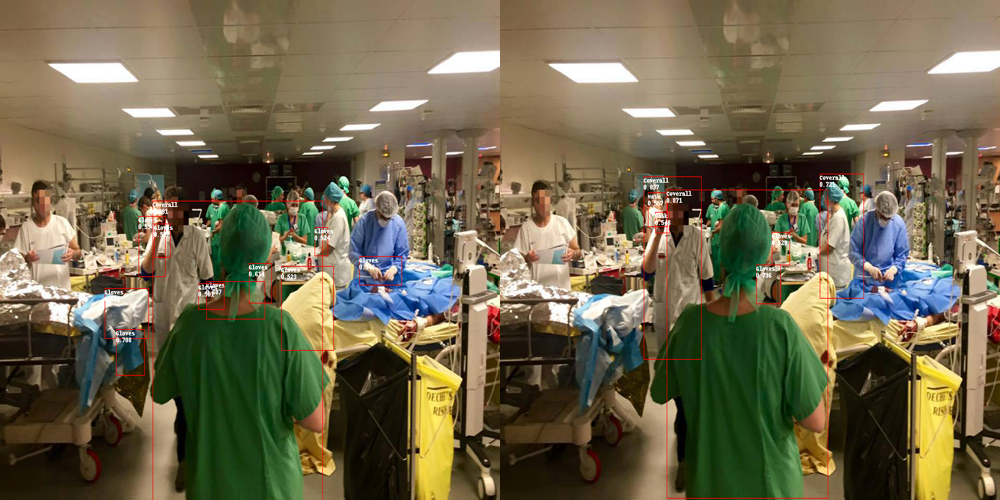

In [63]:
import requests

url = "https://i.imgur.com/vXX5Ckj.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

img_1 = detection(detr_extractor,detr,image).resize((500,500))
img_2 = detection(yolos_extractor,yolos,image).resize((500,500))

# Convert images to numpy arrays
array1 = np.array(img_1)
array2 = np.array(img_2)

# Stack the images horizontally
stacked_image = np.hstack((array1, array2))

# Create a PIL Image from the stacked array
result_image = Image.fromarray(stacked_image)

# Display the result image
result_image.show()

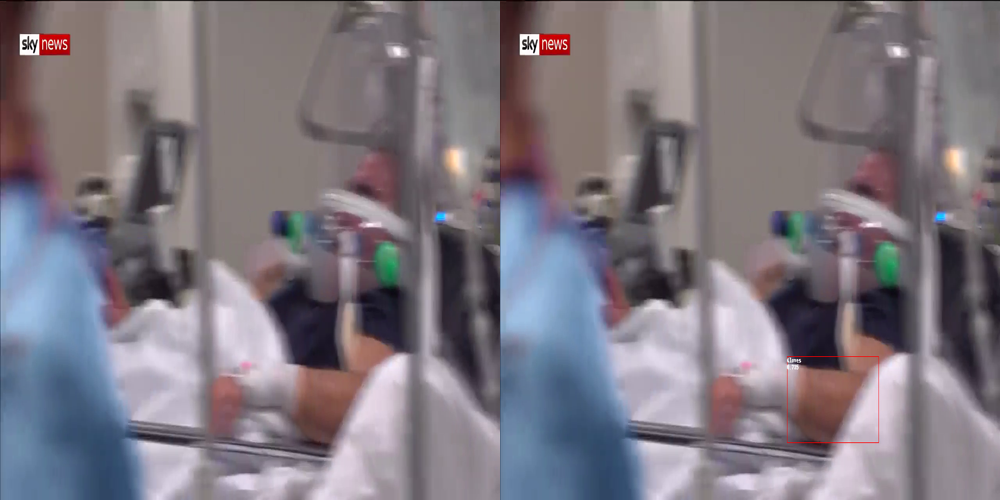

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 13>:40                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [64]:
import cv2 , time
from google.colab.patches import cv2_imshow
import numpy as np
from IPython.display import clear_output

video_path = "/content/drive/MyDrive/Deep_Learning/Final_term/The shocking centre of the COVID-19 crisis_Trim.mp4"

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture(video_path)
  
# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
 
    # Display the resulting frame
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)

    img_1 = detection(detr_extractor,detr,pil_image).resize((500,500))
    img_2 = detection(yolos_extractor,yolos,pil_image).resize((500,500))

    # Convert images to numpy arrays
    array1 = np.array(img_1)
    array2 = np.array(img_2)

    # Stack the images horizontally
    stacked_image = np.hstack((array1, array2))

    # Create a PIL Image from the stacked array
    result_image = Image.fromarray(stacked_image)

    # Display the result image
    result_image.show()
    
    time.sleep(5)
    clear_output()
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
 
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()